In [1]:
## spark imports
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *

In [2]:
## standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:

%matplotlib inline

#Not too sure the following 2 work. This is a TODO
sns.set_color_codes("pastel")
plt.rcParams["figure.figsize"] = [20, 8]

# Reading the Data

In [4]:
spark = SparkSession.builder.appName("chicago_crime_analysis").getOrCreate()
df = spark.read.csv('Crimes_-_2019.csv', inferSchema=True, header=True)

In [5]:
df = df.cache()

# Looking at the data


In [6]:
#How many features do we have
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [15]:
#Total record count:
print(df.count())

211377


## crime types

In [8]:
crime_type_groups = df.groupBy('Primary Type').count()

In [12]:
crime_type_counts = crime_type_groups.orderBy('count', ascending=False)

In [14]:
#These are the top 20 most frequent crime types:
crime_type_counts.show()

+--------------------+-----+
|        Primary Type|count|
+--------------------+-----+
|               THEFT|50332|
|             BATTERY|40949|
|     CRIMINAL DAMAGE|22105|
|             ASSAULT|17143|
|  DECEPTIVE PRACTICE|14041|
|       OTHER OFFENSE|13795|
|           NARCOTICS|11481|
|            BURGLARY| 7780|
| MOTOR VEHICLE THEFT| 7297|
|             ROBBERY| 6400|
|   CRIMINAL TRESPASS| 5614|
|   WEAPONS VIOLATION| 5252|
|OFFENSE INVOLVING...| 1911|
| CRIM SEXUAL ASSAULT| 1318|
|PUBLIC PEACE VIOL...| 1307|
|INTERFERENCE WITH...| 1304|
|         SEX OFFENSE| 1021|
|        PROSTITUTION|  551|
|            HOMICIDE|  426|
|               ARSON|  298|
+--------------------+-----+
only showing top 20 rows



In [16]:
counts_pddf = crime_type_counts.toPandas()

In [17]:
counts_pddf.head(10)

,Primary Type,count
0,THEFT,50332
1,BATTERY,40949
2,CRIMINAL DAMAGE,22105
3,ASSAULT,17143
4,DECEPTIVE PRACTICE,14041
5,OTHER OFFENSE,13795
6,NARCOTICS,11481
7,BURGLARY,7780
8,MOTOR VEHICLE THEFT,7297
9,ROBBERY,6400


[Text(0, 0.5, 'Primary Type'), Text(0.5, 0, 'Crimes Record Count')]

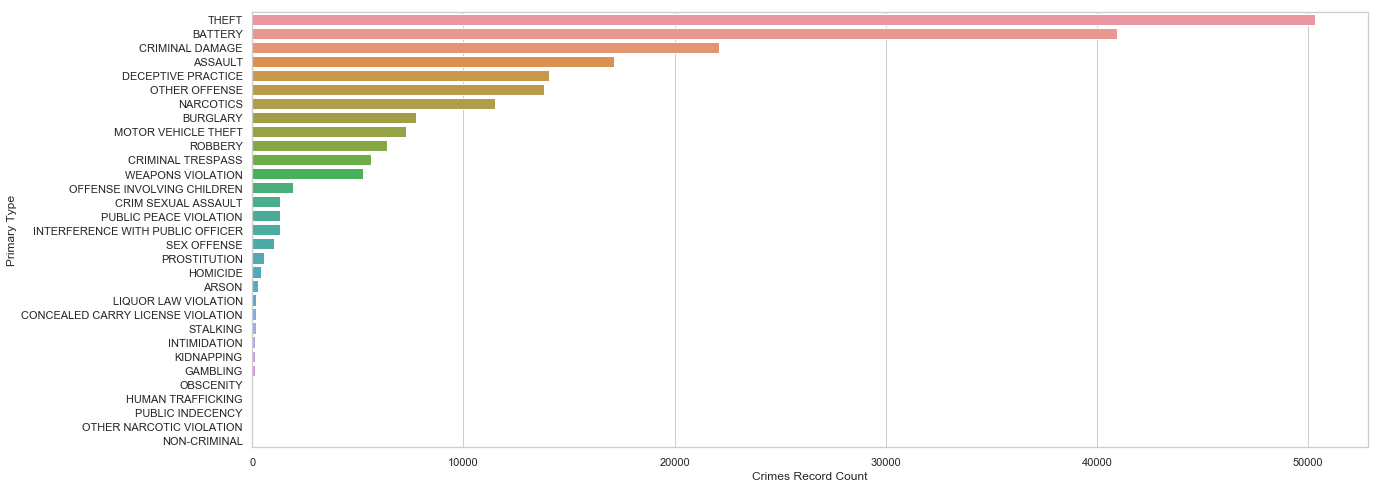

In [21]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

type_graph = sns.barplot(x='count', y='Primary Type', data=counts_pddf)
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

# Recorded Date

In [37]:
import datetime
from pyspark.sql.functions import *

In [38]:
df.select(min('Date').alias('first_record_date'), max('Date').alias('latest_record_date')).show()

+--------------------+--------------------+
|   first_record_date|  latest_record_date|
+--------------------+--------------------+
|01/01/2019 01:00:...|10/23/2019 12:58:...|
+--------------------+--------------------+



So it seems that the dataset we're dealing with comprises records from 2019-01-01 to 2019-10-23

In [39]:
df = df.withColumn('date_time', to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('month', trunc('date_time', 'YYYY')) 

In [41]:
df.select(['date','date_time', 'month']).show(n=2, truncate=False)

+----------------------+-------------------+----------+
|date                  |date_time          |month     |
+----------------------+-------------------+----------+
|10/22/2019 12:00:00 PM|2019-10-22 12:00:00|2019-01-01|
|10/15/2019 10:00:00 AM|2019-10-15 10:00:00|2019-01-01|
+----------------------+-------------------+----------+
only showing top 2 rows



# What time of the day are ciminal the busiest?


In [52]:
df_hour = df.withColumn('hour', hour(df['date_time']))

In [54]:
# Derive a data frame with crime counts per hour of the day:
hourly_count = df_hour.groupBy(['Primary Type', 'hour']).count().cache()
hourly_total_count = hourly_count.groupBy('hour').sum('count')

In [61]:
hourly_count_pddf = hourly_total_count.select(hourly_total_count['hour'], hourly_total_count['sum(count)'].alias('count')).toPandas()
                                

In [62]:
hourly_count_pddf = hourly_count_pddf.sort_values(by='hour')

In [63]:
hourly_count_pddf.head()

,hour,count
23,0.0,10070
3,1.0,6568
22,2.0,5773
7,3.0,4522
14,4.0,3647


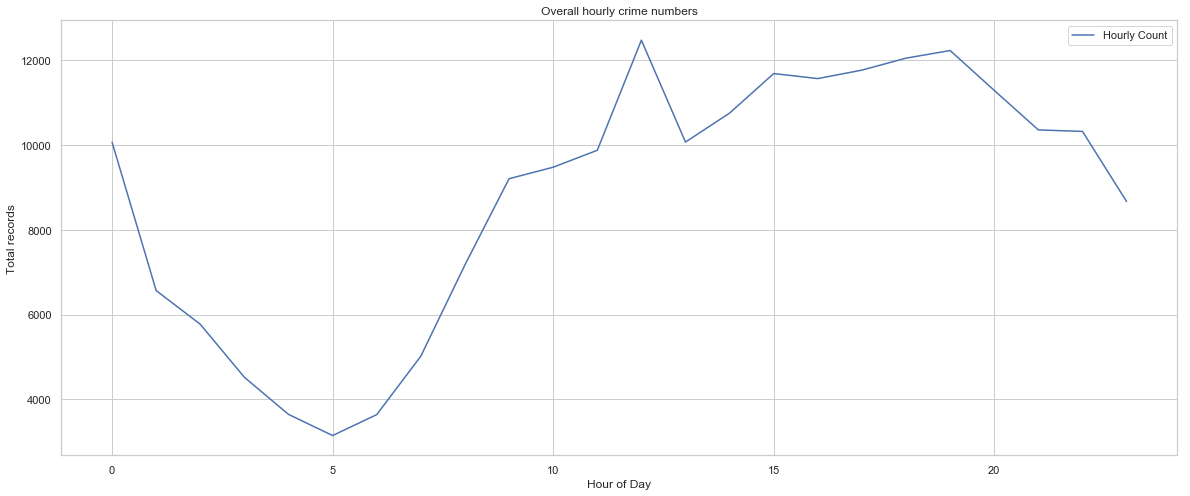

In [64]:
fig, ax = plt.subplots()
ax.plot(hourly_count_pddf['hour'], hourly_count_pddf['count'], label='Hourly Count')

ax.set(xlabel='Hour of Day', ylabel='Total records',
       title='Overall hourly crime numbers')
ax.grid(b=True, which='both', axis='y')
ax.legend()

Seems that 18-22 are the worst hours...

# Types of locations with crime entries

In [67]:
# Number of types of location recorded in the dataset
df.select('Location Description').distinct().count()

124

# What are the top 10 places where crime occurred?

In [68]:
df.groupBy(['Location Description']).count().orderBy('count', ascending=False).show(10)


+--------------------+-----+
|Location Description|count|
+--------------------+-----+
|              STREET|46805|
|           RESIDENCE|34434|
|           APARTMENT|27890|
|            SIDEWALK|16942|
|               OTHER| 8577|
|PARKING LOT/GARAG...| 6218|
|          RESTAURANT| 5677|
|  SMALL RETAIL STORE| 5595|
|               ALLEY| 4257|
|RESIDENTIAL YARD ...| 4030|
+--------------------+-----+
only showing top 10 rows



# A closer look at crime date and time


In [85]:

df_dates = df_hour.withColumn('week_day', dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', month(df_hour['date_time']))\
                 .withColumn('month_day', dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', datediff(df['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [87]:
df_dates.select(['date', 'month', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(20, truncate=False)

+----------------------+----------+----+--------+----+----------+---------+-----------+
|date                  |month     |hour|week_day|year|year_month|month_day|date_number|
+----------------------+----------+----+--------+----+----------+---------+-----------+
|10/22/2019 12:00:00 PM|2019-01-01|12  |3       |2019|10        |22       |6868       |
|10/15/2019 10:00:00 AM|2019-01-01|10  |3       |2019|10        |15       |6861       |
|10/23/2019 09:54:00 AM|2019-01-01|9   |4       |2019|10        |23       |6869       |
|10/20/2019 12:01:00 AM|2019-01-01|0   |1       |2019|10        |20       |6866       |
|10/23/2019 03:40:00 PM|2019-01-01|15  |4       |2019|10        |23       |6869       |
|10/23/2019 08:30:00 PM|2019-01-01|20  |4       |2019|10        |23       |6869       |
|10/23/2019 12:01:00 PM|2019-01-01|12  |4       |2019|10        |23       |6869       |
|10/23/2019 10:00:00 PM|2019-01-01|22  |4       |2019|10        |23       |6869       |
|10/23/2019 12:00:00 PM|2019-01-

# Day of week crime levels


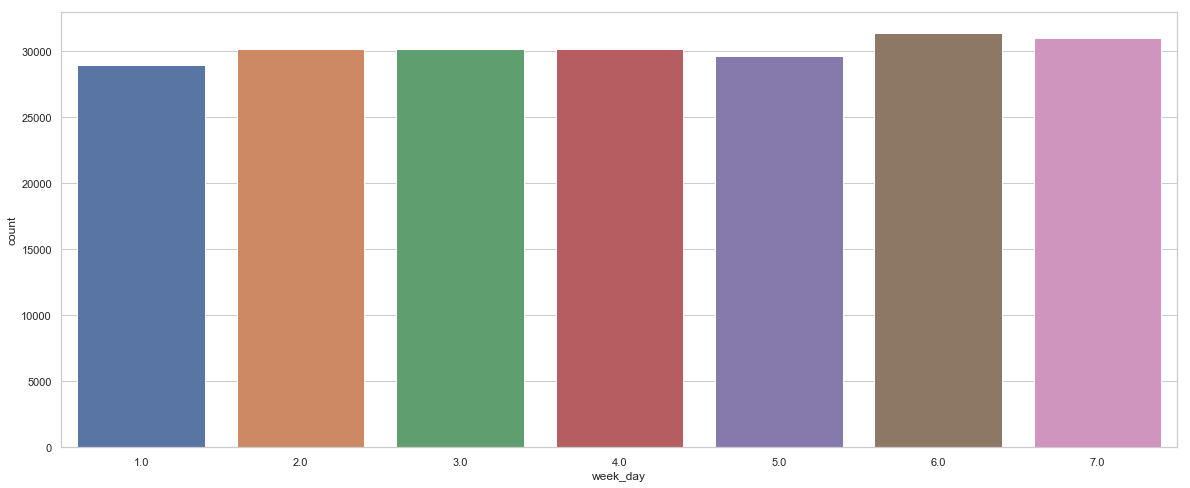

In [89]:
week_day_crime_counts = df_dates.groupBy('week_day').count()
week_day_crime_counts_pddf = week_day_crime_counts.orderBy('week_day').toPandas()
sns.barplot(data=week_day_crime_counts_pddf, x='week_day', y='count')


# Month of year


In [91]:
year_month_crime_counts = df_dates.groupBy('year_month').count()
year_month_crime_counts_pddf = year_month_crime_counts.orderBy('year_month').toPandas().dropna()
year_month_crime_counts_pddf


,year_month,count
1,1.0,19445
2,2.0,18232
3,3.0,20217
4,4.0,20778
5,5.0,23427
6,6.0,23263
7,7.0,24517
8,8.0,23908
9,9.0,21889
10,10.0,15699


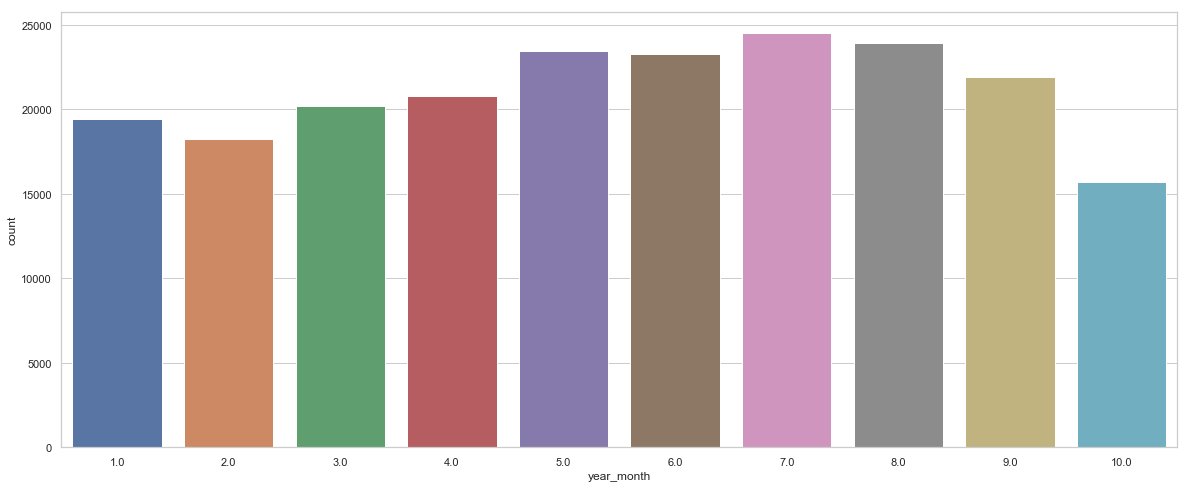

In [92]:
sns.barplot(data=year_month_crime_counts_pddf, y='count', x='year_month')


It seems that May-August are the busiest months for criminals

# Day of month


In [93]:
month_day_crime_counts = df_dates.groupBy('month_day').count()
month_day_crime_counts_pddf = month_day_crime_counts.orderBy('month_day').toPandas()
month_day_crime_counts_pddf.sort_values(by='count', ascending=False).head(10)


,month_day,count
1,1.0,8076
15,15.0,7463
8,8.0,7445
16,16.0,7286
11,11.0,7275
13,13.0,7219
23,23.0,7214
5,5.0,7201
9,9.0,7192
2,2.0,7182


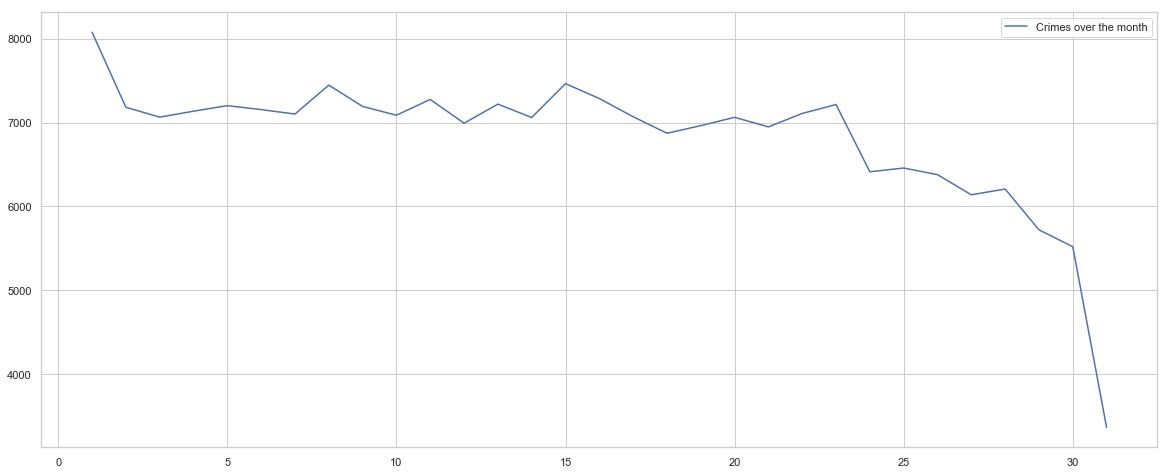

In [94]:
month_day_crime_counts_pddf = month_day_crime_counts_pddf.sort_values(by='month_day', ascending=True)
fg, ax = plt.subplots()

ax.plot(month_day_crime_counts_pddf['month_day'], month_day_crime_counts_pddf['count'], label='Crimes over the month')

ax.grid(b=True, which='both')
ax.legend()

 Community areas?
Chicago has 77 community areas. How do they appear next to one another in a count plot?

In [96]:
df_dates_community_areas = df_dates.na.drop(subset=['Community Area']).groupBy('Community Area').count()


What are the to 10 areas with recorded crime?

In [97]:
df_dates_community_areas.orderBy('count', ascending=False).show(10)


+--------------+-----+
|Community Area|count|
+--------------+-----+
|            25|12011|
|             8|10127|
|            32| 8662|
|            28| 7471|
|            29| 7212|
|            43| 6983|
|            23| 6504|
|            71| 6202|
|            24| 5939|
|            44| 5520|
+--------------+-----+
only showing top 10 rows



Community area names¶

Let's link names of these community areas. These float numbers are having a hard time making any sense...

Sourced from Chicago Tribune at http://www.chicagotribune.com/chi-community-areas-htmlstory.html


In [99]:
area_names = """
01	Rogers Park	
40	Washington Park
02	West Ridge	
41	Hyde Park
03	Uptown	
42	Woodlawn
04	Lincoln Square	
43	South Shore
05	North Center	
44	Chatham
06	Lakeview	
45	Avalon Park
07	Lincoln Park	
46	South Chicago
08	Near North Side	
47	Burnside
09	Edison Park	
48	Calumet Heights
10	Norwood Park	
49	Roseland
11	Jefferson Park	
50	Pullman
12	Forest Glen	
51	South Deering
13	North Park	
52	East Side
14	Albany Park	
53	West Pullman
15	Portage Park	
54	Riverdale
16	Irving Park	
55	Hegewisch
17	Dunning	
56	Garfield Ridge
18	Montclare	
57	Archer Heights
19	Belmont Cragin	
58	Brighton Park
20	Hermosa	
59	McKinley Park
21	Avondale	
60	Bridgeport
22	Logan Square	
61	New City
23	Humboldt Park	
62	West Elsdon
24	West Town	
63	Gage Park
25	Austin	
64	Clearing
26	West Garfield Park 	
65	West Lawn
27	East Garfield Park	
66	Chicago Lawn
28	Near West Side	
67	West Englewood
29	North Lawndale	
68	Englewood
30	South Lawndale	
69	Greater Grand Crossing
31	Lower West Side	
70	Ashburn
32	Loop	
71	Auburn Gresham	
33	Near South Side	
72	Beverly
34	Armour Square	
73	Washington Heights
35	Douglas	
74	Mount Greenwood
36	Oakland	
75	Morgan Park
37	Fuller Park	
76	O'Hare
38	Grand Boulevard	
77	Edgewater
39	Kenwood	
"""